In [1]:
import tensorflow as tf
import os
#import keras
from tensorflow import keras
import tensorflow.keras.layers as kl
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dropout, Reshape, Dense, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, InputLayer, Input
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint

In [2]:
tf.config.experimental.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
### set GPU for tensorflow
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import pandas as pd
import numpy as np

import sys
sys.path.append('Neural_Network_DNA_Demo/')
from helper import IOHelper, SequenceHelper # from https://github.com/const-ae/Neural_Network_DNA_Demo

import random
random.seed(1234)

## Data

In [5]:
%%bash
source ../config_sing.sh
ls ${FD_RES}/peak/cradle_deepstarr_data/chr17.fa
ls ${FD_RES}/peak/cradle_peak_count/results/dat_score_chr17.tsv

/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr17.fa
/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr17.tsv


In [6]:
%%bash
source ../config_sing.sh
head -2 ${FD_RES}/peak/cradle_deepstarr_data/chr17.fa

>chr17:409725-410725
atcccagcgatctaggaggccgaggcgggaagatcgatggagcccaggagttcgagaccagcctgaaaccaaaaatcaaaactcttagccaggcgtggGGATGGGAGGCCAAGGCAGGAGGATCGAGGCACGGGACTGGACGAGATGAGTGTCAGCCCAGGGATTTAAAATCTCTCTGCCCACCCTCCCCTTCCTGCGGTCAACTGTCCAGATTCCAACAGACAAAAGCAAGCATGGGCGAACCACCGTGCGCCGCGGTCCCCGACAGAAGCACGCATGCGCACACCTCTGTGTGCGGAGGTTTCCGACAGACGCACGCATGCGCACACTTCTATGCGCGGAGGTCTCCGCAGACAGAAGCACGCATGCGCACATCGCTGTGCCGGTATCGCCAACAGATGGAAGCACGCATGCGCGCACCGCTGCGTACCTAGCACTCCGACAGATGTACGCATGCGCACAACGCTCTGTTCTCGAGATCCCCGACAGAAGCACACATGCGCACACCGCTGTGTGCCAAGGTCGCCAAAAGACGGAAGCACGCATGCGCACACCGCGGTCCGTGGGGCACCGGGCGGAAGCGTCCTGACTGCGCAGGCGCAGCAGGGGTGGTCGCCATGGAGACGCGTGGCCCTGGCCTGGCGGTCCGCGCTGAGAGTCGCCGATTAGTCGGCATCGGGCCTCGGGCGCCCCCGGGGCGGGTTGGGTTGCAGCCCAGCGGGCGGCTGGACCGCCGCGGTGGGGCGGGGACAATGGGGTACAAGGACAACGACGGCGAGGAGGAGGAGCGGGAGGGCGGCGCCGCGGGCCCGCGGGGGTCTAGACTGCCCCCCATCACAGGCGGCGCCTCCGAGCTGGCCAAACGgaaggtgaagaagaaaaaaaggaagaagaagaCCAAGGGGTCTGGCAAGGGGGACGGTAAGAGGAGCAGCTAGCCCGGCTGCGTCAGCTCCGGTTCCCTGGAGACTCTTTGGGG

In [71]:
dat_fasta = IOHelper.get_fastas_from_file(
    "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr17.fa", 
    uppercase=True)
dat = dat_fasta.head()

In [72]:
dat.sequence

0    ATCCCAGCGATCTAGGAGGCCGAGGCGGGAAGATCGATGGAGCCCA...
1    CAACTGTCCAGATTCCAACAGACAAAAGCAAGCATGGGCGAACCAC...
2    GCGGCTCAGCCCCTGGAAGTCAGGAGTGTTTCCATAGTCCTGAGCA...
3    ACTCCAAAGGCAGGCTCAAAGGTCTCCATGGTACTCCAGGGCCCCT...
4    TGGTTTTTTTTTTGTTGTTGTTTTTTGAGACAGTCTCACTCTGGCT...
Name: sequence, dtype: object

In [74]:
seq_matrix = SequenceHelper.do_one_hot_encoding(
        dat.sequence, 
        sequence_length,
        SequenceHelper.parse_alpha_to_seq)

In [85]:
CHROMS = np.r_[np.arange(16,18).astype(str)]
CHROMS

array(['16', '17'], dtype='<U21')

In [86]:
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data"
lst = list()
sequence_length = 1000

for chrom in CHROMS:
    fname = "chr" + chrom + ".fa"
    fpath = os.path.join(fdiry, fname)
    print(fpath, flush = True)
    dat = IOHelper.get_fastas_from_file(fpath, uppercase=True)
    lst.append(dat)

dat_fasta = pd.concat(lst)
dat_fasta

/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr16.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr17.fa


,location,sequence
0,chr16:34925-35925,TGCTCCAGGTCAGGATGCAGTGGCTAGAGCTGATGTTGCCCTGCAA...
1,chr16:56150-57150,GGGACACTGTCGGGAATTTCCAGTGTGTCTGGAAGTGGCCTCCCTA...
2,chr16:66625-67625,CTCACGCTCCAGCCCCTTATCTGAGCTGACTGTGCACTTCAGGTCC...
3,chr16:67835-68835,TCAAGATGACCTCTCAGCTGGGTCTGGGAAGACGAGCTGCCTGGCA...
4,chr16:69250-70250,CCTCAGGTGTGAGCAGCAACCACCTCTGTACTCAGGCCTGCCCTGC...
...,...,...
3596,chr17:83196603-83197603,CCTGGGTGAGGACCTGGTATCCTCAAAGTCCCCGTGGCTGCCCTGT...
3597,chr17:83199918-83200918,TGTAAAACTGACTAAAGGAGAAGTTGGTGTCTTCCTCATACAAGAA...
3598,chr17:83199933-83200933,AGGAGAAGTTGGTGTCTTCCTCATACAAGAAATACATAAATCAGTT...
3599,chr17:83202438-83203438,GAGGCTCTCTATAGAATGGGTACTTGTCAACAAAGTGGGCTTAGAC...


In [87]:
dat = dat_fasta.reset_index()
dat

,index,location,sequence
0,0,chr16:34925-35925,TGCTCCAGGTCAGGATGCAGTGGCTAGAGCTGATGTTGCCCTGCAA...
1,1,chr16:56150-57150,GGGACACTGTCGGGAATTTCCAGTGTGTCTGGAAGTGGCCTCCCTA...
2,2,chr16:66625-67625,CTCACGCTCCAGCCCCTTATCTGAGCTGACTGTGCACTTCAGGTCC...
3,3,chr16:67835-68835,TCAAGATGACCTCTCAGCTGGGTCTGGGAAGACGAGCTGCCTGGCA...
4,4,chr16:69250-70250,CCTCAGGTGTGAGCAGCAACCACCTCTGTACTCAGGCCTGCCCTGC...
...,...,...,...
7073,3596,chr17:83196603-83197603,CCTGGGTGAGGACCTGGTATCCTCAAAGTCCCCGTGGCTGCCCTGT...
7074,3597,chr17:83199918-83200918,TGTAAAACTGACTAAAGGAGAAGTTGGTGTCTTCCTCATACAAGAA...
7075,3598,chr17:83199933-83200933,AGGAGAAGTTGGTGTCTTCCTCATACAAGAAATACATAAATCAGTT...
7076,3599,chr17:83202438-83203438,GAGGCTCTCTATAGAATGGGTACTTGTCAACAAAGTGGGCTTAGAC...


In [63]:
dat_fasta.shape

(10, 2)

In [67]:
for seq in dat_fasta.sequence:
    print(len(seq))

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [68]:
dat_fasta.sequence

0    TGCTCCAGGTCAGGATGCAGTGGCTAGAGCTGATGTTGCCCTGCAA...
1    GGGACACTGTCGGGAATTTCCAGTGTGTCTGGAAGTGGCCTCCCTA...
2    CTCACGCTCCAGCCCCTTATCTGAGCTGACTGTGCACTTCAGGTCC...
3    TCAAGATGACCTCTCAGCTGGGTCTGGGAAGACGAGCTGCCTGGCA...
4    CCTCAGGTGTGAGCAGCAACCACCTCTGTACTCAGGCCTGCCCTGC...
0    ATCCCAGCGATCTAGGAGGCCGAGGCGGGAAGATCGATGGAGCCCA...
1    CAACTGTCCAGATTCCAACAGACAAAAGCAAGCATGGGCGAACCAC...
2    GCGGCTCAGCCCCTGGAAGTCAGGAGTGTTTCCATAGTCCTGAGCA...
3    ACTCCAAAGGCAGGCTCAAAGGTCTCCATGGTACTCCAGGGCCCCT...
4    TGGTTTTTTTTTTGTTGTTGTTTTTTGAGACAGTCTCACTCTGGCT...
Name: sequence, dtype: object

In [88]:
seq_matrix = SequenceHelper.do_one_hot_encoding(
        dat.sequence, 
        sequence_length,
        SequenceHelper.parse_alpha_to_seq)

In [89]:
CHROMS = np.r_[np.arange(1,23), ["X"]]
CHROMS

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X'],
      dtype='<U21')

In [90]:
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data"
lst = list()
sequence_length = 1000

for chrom in CHROMS:
    fname = "chr" + chrom + ".fa"
    fpath = os.path.join(fdiry, fname)
    print(fpath, flush = True)
    dat = IOHelper.get_fastas_from_file(fpath, uppercase=True)
    lst.append(dat)

dat_fasta = pd.concat(lst).reset_index()
dat_fasta

/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr1.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr2.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr3.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr4.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr5.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr6.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr7.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr8.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr9.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr10.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr11.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr12.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr13.fa
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_d

,index,location,sequence
0,0,chr1:778232-779232,TCCCTGTTGCACACCTGGATAGTTTTTTAAATTTTTTTAGACAGGG...
1,1,chr1:818441-819441,ATGCTTACCAGGGCTGGAGGCCCCTGTGAGTAGTGAAGTGCATGTG...
2,2,chr1:826644-827644,ATTCTGTCCTCCATATCTCTGCTGATTCCCATTTTGTCTATTTCCA...
3,3,chr1:851117-852117,TGTCTTTATAGCAGCATGATTTATAGTCCTTTGGGTATATACCCAG...
4,4,chr1:856205-857205,CATTCCCGGATCCAAGGTCCTGCCTCTGTCCTGTCCCCTGAGCCAC...
...,...,...,...
87904,3426,chrX:155434820-155435820,TTTTTCAAAAGAAAAGCAATGAGGATCAGAAAGGTGAAGATACTAG...
87905,3427,chrX:155435206-155436206,ACGCTCTTCCCATGTATCTTTGTAATTTGCTGATCAGGAGATCCCC...
87906,3428,chrX:155440330-155441330,AAGGGGAGGCAAACACATCCTTCTTCACAGGGTGGCAGCAAGGAGA...
87907,3429,chrX:155521212-155522212,TTTCTGGTTGTTAGTTTTCCTTCTAACAGACAGGACCCTCAGCTGC...


dat_fasta = IOHelper.get_fastas_from_file(
    "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr17.fa", 
    uppercase=True)

In [41]:
len(dat_fasta.sequence.to_numpy()[0])

1000

In [36]:
seq = dat_fasta.sequence[0]
print(len(seq))
print(seq)

10
0    TCCCTGTTGCACACCTGGATAGTTTTTTAAATTTTTTTAGACAGGG...
0    GGCCCGCCTCCCTGGCCGCTCTCCGGGTGCCAGCGCCCGCCCTCAC...
0    ATAAAAGTCCCAAAATGTGCAAATAGGTGTCACGGACATCTCTAAA...
0    AGCTCGGTTAGGGCCTCATCGCTCTGCTCCCGCTCCTTAGGGAAGC...
0    CTCTGCCTGATTTCTCCAGAATTTTGAAATTCTAACTGAATACTCT...
0    TGGTTCTTTTTGGTGGGTTCTTGGTCTCGCAGACTTCAAGAATGAA...
0    GTGACCTGAGCTCTCCCGGTGTCACATTCTCCACATCTGAGCCCTC...
0    GTCTCCGCGGATGTCACAGGCTCGGCAACCGCCCTCCTGTCGGCGG...
0    CCACGTGTCGGGCATTTTACAGACGGGACATCCTTTAATGGCAACA...
0    CAGGAAGATACGAGACAACTAGTTGCATTCTTCTAAGTCCTTGATC...
Name: sequence, dtype: object


In [9]:
dat_fasta.head()

,location,sequence
0,chr17:409725-410725,ATCCCAGCGATCTAGGAGGCCGAGGCGGGAAGATCGATGGAGCCCA...
1,chr17:409925-410925,CAACTGTCCAGATTCCAACAGACAAAAGCAAGCATGGGCGAACCAC...
2,chr17:494432-495432,GCGGCTCAGCCCCTGGAAGTCAGGAGTGTTTCCATAGTCCTGAGCA...
3,chr17:497086-498086,ACTCCAAAGGCAGGCTCAAAGGTCTCCATGGTACTCCAGGGCCCCT...
4,chr17:502352-503352,TGGTTTTTTTTTTGTTGTTGTTTTTTGAGACAGTCTCACTCTGGCT...


In [43]:
len(dat_fasta)

48528

In [42]:
# get length of first sequence
sequence_length = len(dat_fasta.sequence.iloc[0])
print(sequence_length)

1000


In [91]:
# Convert sequence to one hot encoding matrix
seq_matrix = SequenceHelper.do_one_hot_encoding(
    dat_fasta.sequence, 
    sequence_length,
    SequenceHelper.parse_alpha_to_seq)

In [93]:
print(seq_matrix.shape)

(87909, 1000, 4)


In [94]:
X = np.nan_to_num(seq_matrix) # Replace NaN with zero and infinity with large finite numbers
X_reshaped = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [95]:
fdiry
fpath = "/home/mount/work/out/proj_combeffect/peak/cradle_peak_count/results/dat_score_chr17.tsv"

lst = list()
for 
Activity = pd.read_table(fpath)
Y_dmso = Activity.Log2_Score_DMSO
Y_dex  = Activity.Log2_Score_Dex
#Y      = [Y_dmso, Y_dex]
Y = np.array([Y_dmso, Y_dex])
Y = Y.T

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
print(X_reshaped.shape)
print(Y.shape)

(87909, 1000, 4)
(3601, 2)


In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_reshaped, 
    Y, 
    test_size=0.1, 
    random_state=42)

In [17]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(3240, 1000, 4)
(361, 1000, 4)
(3240, 2)
(361, 2)


In [18]:
Y_train = [y_train[:,0], y_train[:,1]]
Y_valid = [y_valid[:,0], y_valid[:,1]]

In [19]:
print(X_train.shape)
print(X_valid.shape)
print(Y_train[0].shape)
print(Y_valid[0].shape)

(3240, 1000, 4)
(361, 1000, 4)
(3240,)
(361,)


In [20]:
### Additional metrics
from scipy.stats import spearmanr
def Spearman(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32), 
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )

In [21]:
params = {'batch_size': 128,
          'epochs': 100,
          'early_stop': 10,
          'kernel_size1': 7,
          'kernel_size2': 3,
          'kernel_size3': 5,
          'kernel_size4': 3,
          'kernel_size5': 3,
          'lr': 0.002,
          'num_filters': 256,
          'num_filters2': 60,
          'num_filters3': 60,
          'num_filters4': 120,
          'num_filters5': 120,
          #'n_conv_layer': 4,
          'n_conv_layer': 5,
          'n_add_layer':  2,
          'dropout_prob': 0.4,
          'dense_neurons1': 256,
          'dense_neurons2': 256,
          'pad':'same'}

def DeepSTARR(params=params):
    
    lr = params['lr']
    dropout_prob = params['dropout_prob']
    n_conv_layer = params['n_conv_layer']
    n_add_layer = params['n_add_layer']
    
    # body
    #input = kl.Input(shape=(249, 4))
    input = kl.Input(shape=(1000, 4))
    x = kl.Conv1D(params['num_filters'], kernel_size=params['kernel_size1'],
                  padding=params['pad'],
                  name='Conv1D_1st')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)

    for i in range(1, n_conv_layer):
        x = kl.Conv1D(params['num_filters'+str(i+1)],
                      kernel_size=params['kernel_size'+str(i+1)],
                      padding=params['pad'],
                      name=str('Conv1D_'+str(i+1)))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    # dense layers
    for i in range(0, n_add_layer):
        x = kl.Dense(params['dense_neurons'+str(i+1)],
                     name=str('Dense_'+str(i+1)))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_prob)(x)
    bottleneck = x
    
    # heads per task (developmental and housekeeping enhancer activities)
    #tasks = ['Dev', 'Hk']
    tasks = ['DMSO', 'Dex']
    outputs = []
    for task in tasks:
        outputs.append(kl.Dense(1, activation='linear', name=str('Dense_' + task))(bottleneck))

    model = tf.keras.models.Model([input], outputs)
    model.compile(tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=['mse', 'mse'], # loss
                  loss_weights=[1, 1], # loss weigths to balance
                  metrics=[Spearman]) # additional track metric

    return model, params

DeepSTARR()[0].summary()
DeepSTARR()[1] # dictionary

W0109 13:40:02.254576 140524259751744 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
Conv1D_1st (Conv1D)             (None, 1000, 256)    7424        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1000, 256)    1024        Conv1D_1st[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 1000, 256)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

{'batch_size': 128,
 'epochs': 100,
 'early_stop': 10,
 'kernel_size1': 7,
 'kernel_size2': 3,
 'kernel_size3': 5,
 'kernel_size4': 3,
 'kernel_size5': 3,
 'lr': 0.002,
 'num_filters': 256,
 'num_filters2': 60,
 'num_filters3': 60,
 'num_filters4': 120,
 'num_filters5': 120,
 'n_conv_layer': 5,
 'n_add_layer': 2,
 'dropout_prob': 0.4,
 'dense_neurons1': 256,
 'dense_neurons2': 256,
 'pad': 'same'}

In [22]:
def train(selected_model, X_train, Y_train, X_valid, Y_valid, params):

    my_history=selected_model.fit(X_train, Y_train,
                                  validation_data=(X_valid, Y_valid),
                                  batch_size=params['batch_size'], epochs=params['epochs'],
                                  callbacks=[EarlyStopping(patience=params['early_stop'], monitor="val_loss", restore_best_weights=True),
                                             History()])
    
    return selected_model, my_history

In [23]:
main_model, main_params = DeepSTARR()
main_model, my_history = train(main_model, X_train, Y_train, X_valid, Y_valid, main_params)

Train on 3240 samples, validate on 361 samples
Epoch 1/100
3240/3240 [==============================] - 4s 1ms/sample - loss: 3.5018 - Dense_DMSO_loss: 1.6823 - Dense_Dex_loss: 1.7709 - Dense_DMSO_Spearman: 0.0964 - Dense_Dex_Spearman: 0.0130 - val_loss: 4.3531 - val_Dense_DMSO_loss: 1.6419 - val_Dense_Dex_loss: 2.7227 - val_Dense_DMSO_Spearman: 0.2875 - val_Dense_Dex_Spearman: 0.0411
Epoch 2/100
3240/3240 [==============================] - 1s 275us/sample - loss: 2.3361 - Dense_DMSO_loss: 1.1655 - Dense_Dex_loss: 1.1586 - Dense_DMSO_Spearman: 0.1325 - Dense_Dex_Spearman: 0.0933 - val_loss: 3.4997 - val_Dense_DMSO_loss: 1.4607 - val_Dense_Dex_loss: 2.0561 - val_Dense_DMSO_Spearman: 0.3452 - val_Dense_Dex_Spearman: 0.0627
Epoch 3/100
3240/3240 [==============================] - 1s 274us/sample - loss: 1.8148 - Dense_DMSO_loss: 0.8969 - Dense_Dex_loss: 0.9014 - Dense_DMSO_Spearman: 0.2167 - Dense_Dex_Spearman: 0.1500 - val_loss: 2.9052 - val_Dense_DMSO_loss: 1.4055 - val_Dense_Dex_loss: 

In [24]:
my_history

In [25]:
my_history.history.keys()

dict_keys(['loss', 'Dense_DMSO_loss', 'Dense_Dex_loss', 'Dense_DMSO_Spearman', 'Dense_Dex_Spearman', 'val_loss', 'val_Dense_DMSO_loss', 'val_Dense_Dex_loss', 'val_Dense_DMSO_Spearman', 'val_Dense_Dex_Spearman'])

In [26]:
def plot_loss_acc(axs, history, has_validate=False):
    """..."""
    ### history
    h = history
    loss_trn = h["loss"]
    acc_trn  = h["Dense_Dex_Spearman"]
    x = np.arange(len(loss_trn)) + 1
    
    ### plot loss
    ax = axs[0]
    ax.plot(x, loss_trn, "o-", color="blue", label="Train")
    ax.set_title("Loss")
    
    ### plot accuracy
    ax = axs[1]
    ax.plot(x, acc_trn, "o-", color="blue", label="Train")
    ax.set_title("Dense_Dex_Spearman")
    
    ### plot validation if has_validate
    if has_validate:
        loss_val = h["val_loss"]
        acc_val  = h["val_Dense_Dex_Spearman"]
    
        ax = axs[0]
        ax.plot(x, loss_val, "o-", color="orange", label="Validation")
        ax.set_title("Loss (Validation)")
        
        ax = axs[1]
        ax.plot(x, acc_val, "o-", color="orange", label="Validation")
        ax.set_title("val_Dense_Dex_Spearman")

In [27]:
import matplotlib.pyplot as plt

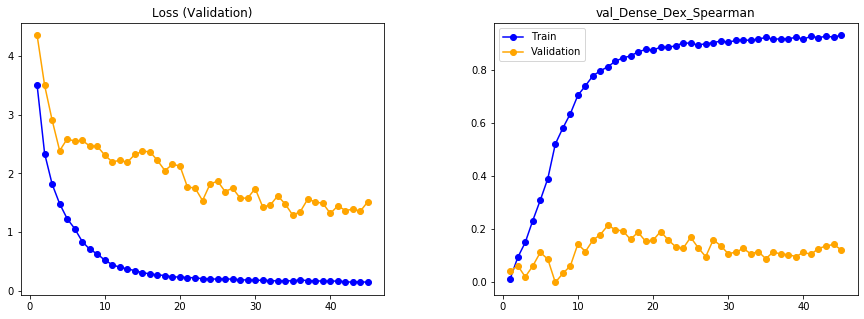

In [28]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plot_loss_acc(axes, my_history.history, has_validate=True)
plt.legend()
plt.show()

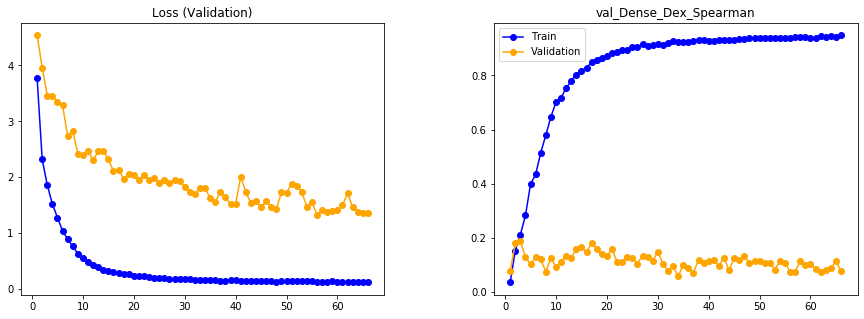

In [36]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plot_loss_acc(axes, my_history.history, has_validate=True)
plt.legend()
plt.show()

In [29]:
from scipy import stats
from sklearn.metrics import mean_squared_error

# create functions
#tasks = ['DMSO', 'Dex']
TASK1 = 'DMSO'
TASK2 = 'Dex'
def summary_statistics(X, Y, set, task):
    pred = main_model.predict(X, batch_size=main_params['batch_size'])
    #if task =="Dev":
    if task == TASK1:
        i=0
    #if task =="Hk":
    if task == TASK2:
        i=1
    print(set + ' MSE ' + task + ' = ' + str("{0:0.2f}".format(mean_squared_error(Y, pred[i].squeeze()))))
    print(set + ' PCC ' + task + ' = ' + str("{0:0.2f}".format(stats.pearsonr(Y, pred[i].squeeze())[0])))
    print(set + ' SCC ' + task + ' = ' + str("{0:0.2f}".format(stats.spearmanr(Y, pred[i].squeeze())[0])))
    
# run for each set and enhancer type
#summary_statistics(X_train, Y_train[0], "train", "Dev")
#summary_statistics(X_train, Y_train[1], "train", "Hk")
#summary_statistics(X_valid, Y_valid[0], "validation", "Dev")
#summary_statistics(X_valid, Y_valid[1], "validation", "Hk")
#summary_statistics(X_test, Y_test[0], "test", "Dev")
#summary_statistics(X_test, Y_test[1], "test", "Hk")

summary_statistics(X_train, Y_train[0], "train", TASK1)
summary_statistics(X_train, Y_train[1], "train", TASK2)
summary_statistics(X_valid, Y_valid[0], "validation", TASK1)
summary_statistics(X_valid, Y_valid[1], "validation", TASK2)
#summary_statistics(X_test, Y_test[0], "test", TASK1)
#summary_statistics(X_test, Y_test[1], "test", TASK2)

train MSE DMSO = 0.08
train PCC DMSO = 0.98
train SCC DMSO = 0.98
train MSE Dex = 0.03
train PCC Dex = 0.97
train SCC Dex = 0.97
validation MSE DMSO = 0.55
validation PCC DMSO = 0.47
validation SCC DMSO = 0.46
validation MSE Dex = 0.73
validation PCC Dex = 0.16
validation SCC Dex = 0.10


In [30]:
import os

In [31]:
ls /home/mount/work/out/proj_combeffect/peak

cradle/  cradle_deepstarr_data/  cradle_deepstarr_results/  cradle_peak_count/


In [32]:
fdiry = "/home/mount/work/out/proj_combeffect/peak"
os.listdir(fdiry)

['.ipynb_checkpoints',
 'cradle_deepstarr_results',
 'cradle_peak_count',
 'cradle',
 'cradle_deepstarr_data']

In [33]:
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
os.listdir(fdiry)

['Model_DeepSTARR.json', 'Model_DeepSTARR.h5']

In [34]:
#model_name="DeepSTARR"

#model_json = main_model.to_json()
#with open('Model_' + model_name + '.json', "w") as json_file:
#    json_file.write(model_json)
#main_model.save_weights('Model_' + model_name + '.h5')

model_name = "DeepSTARR"
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results" 

model_json = main_model.to_json()
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
fname = 'Model_' + model_name + '.json'
fpath = os.path.join(fdiry, fname)
with open(fpath, "w") as json_file:
    json_file.write(model_json)
    
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
fname = 'Model_' + model_name + '.h5'
fpath = os.path.join(fdiry, fname)
main_model.save_weights(fpath)